In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Introduction
In this Notebook we show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost
 
In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e.for
the columns that have only two possible values or more than two sortable values. The only column that has not these characteristic is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analyzing the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost, XGBoost shows the best performance, so we decide to optimize
its hyperparameters by using the framework Optuna.

Finally we perfrom the predictions in two ways:

 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5


## 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


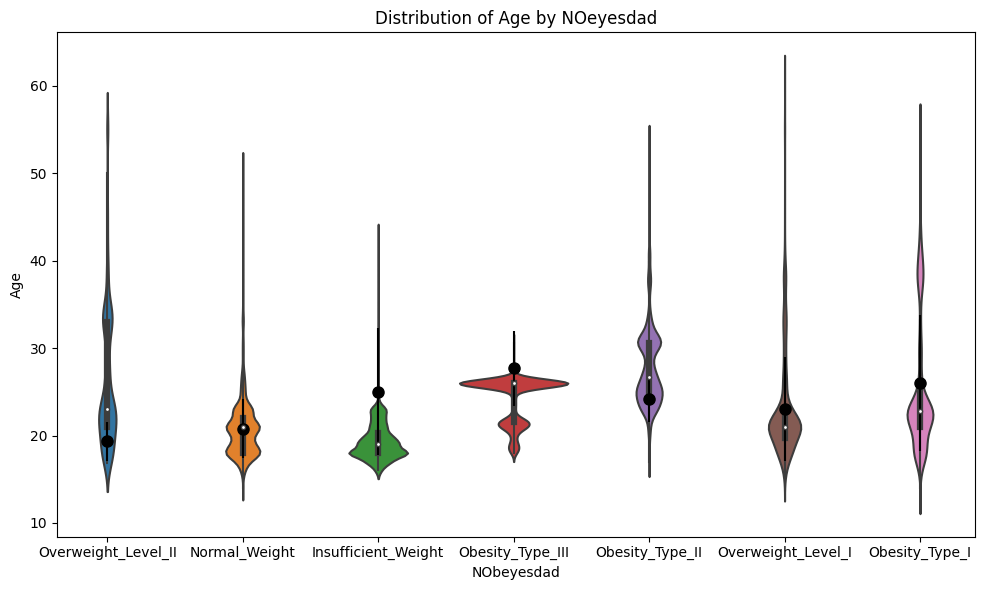

In [4]:
# 'NOeyesdad' 별 'age'의 평균과 분산 계산
grouped_data = df.groupby('NObeyesdad')['Age'].agg(['mean', 'std'])

# 바이올린 차트로 시각화
plt.figure(figsize=(10,6))
grouped_data.reset_index(inplace=True)
sns.violinplot(x='NObeyesdad', y='Age', data=df)
plt.title('Distribution of Age by NOeyesdad')
plt.xlabel('NObeyesdad')
plt.ylabel('Age')
plt.errorbar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], fmt='o', color='black', markersize=8)
plt.tight_layout()
plt.show()

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


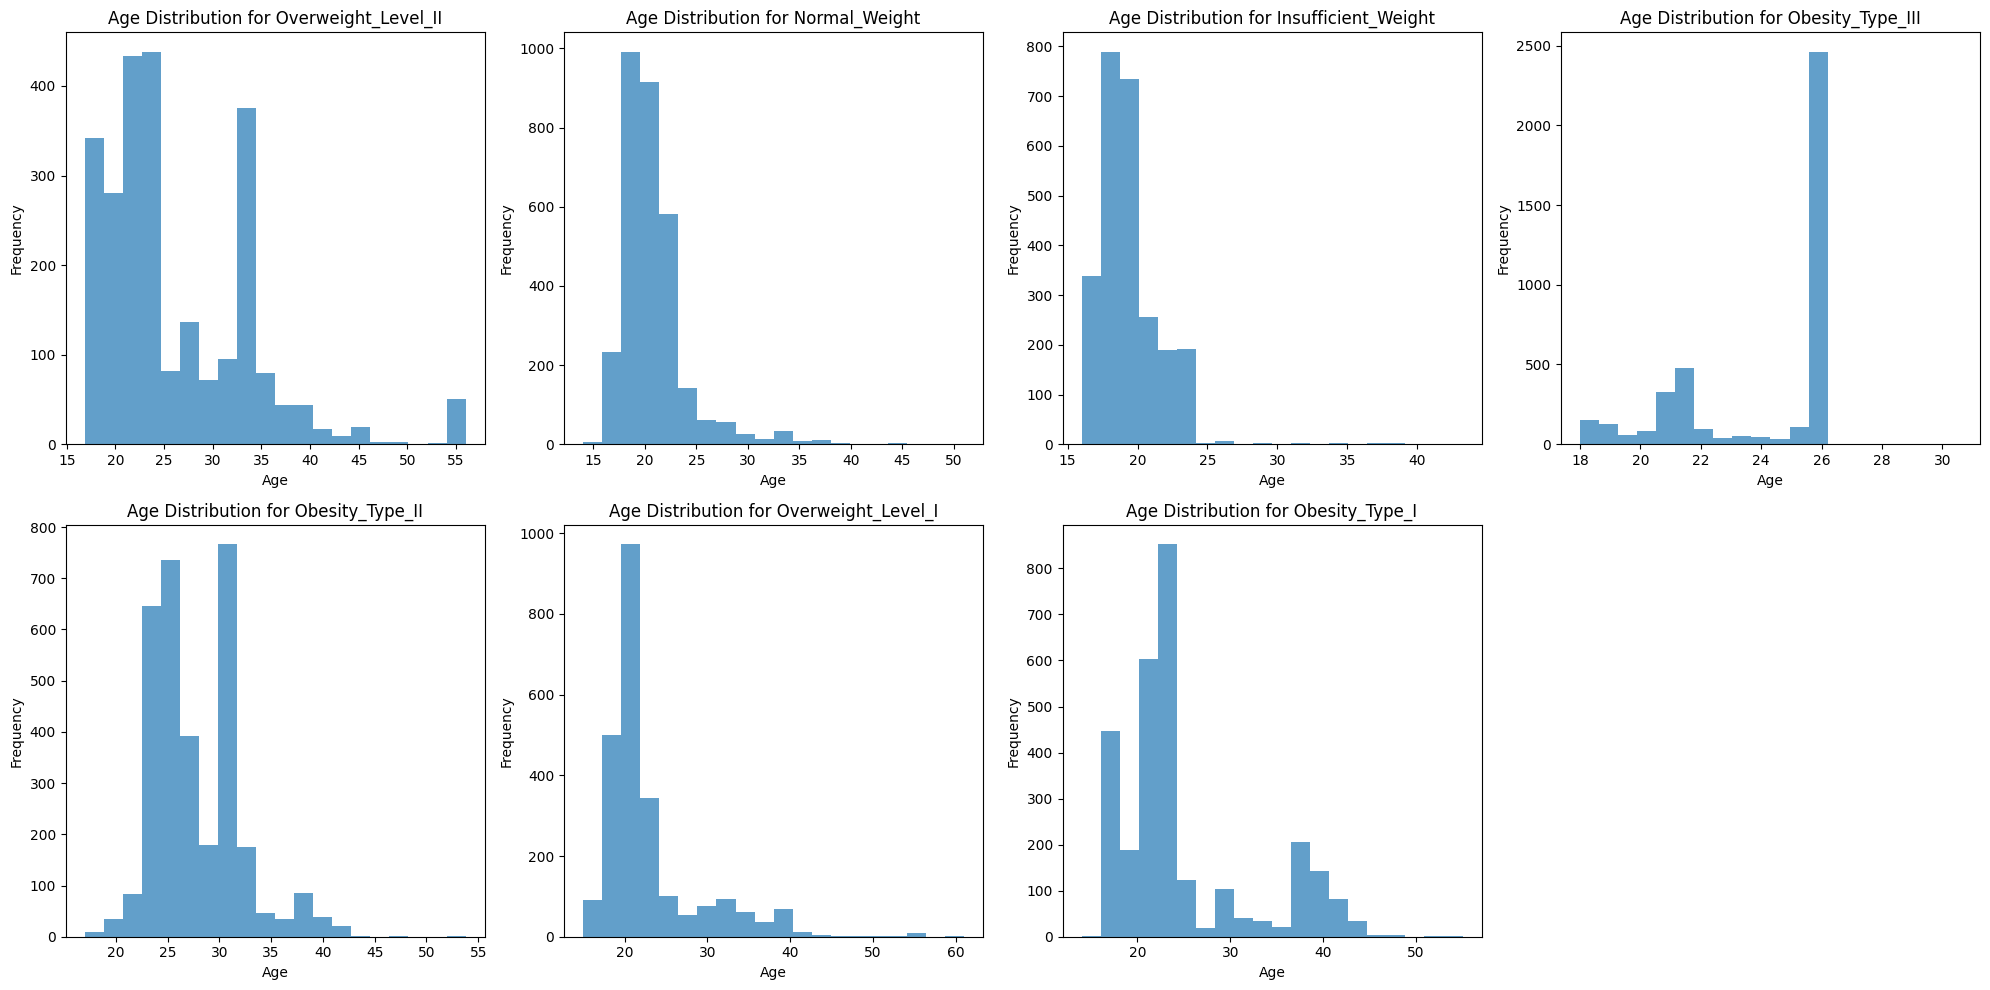

In [5]:
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

# train_data 결측치 없음을 확인.
df.isnull().sum()

In particular we can deduct that:

- 'Gender', 'Age', 'Height', 'Weight' are physical attributes
- 'family_history_with_overweight' points out to familiarity with obesity
- FAVC = Frequent consumption of high caloric food
- FCVC = Frequency of consumption of vegetables
- NCP = Number of main meals
- CAEC = Consumption of food between meals
- SMOKE = tobacco usage
- CH20 = Consumption of water daily
- SCC = Calories consumption monitoring
- FAF = Physical activity frequency
- TUE = Time using technology devices
-CALC = Consumption of alcohol
MTRANS = Transportation used

In [6]:
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

## 2.Data exploration and pre-processing

### Numerical DataFrame

In [7]:
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
id,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721
...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

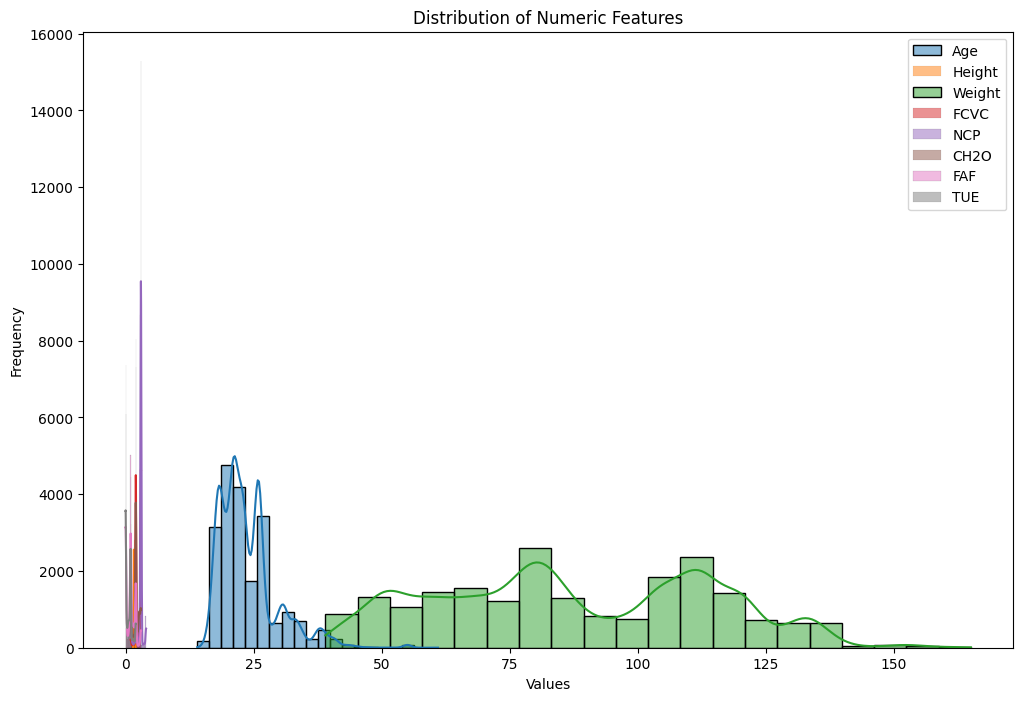

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 각 숫자형 변수에 대한 히스토그램 시각화
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

for column in df_numerical.columns:
    sns.histplot(df_numerical[column], kde=True, bins=20, label=column)

plt.title("Distribution of Numeric Features")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [9]:
## 여기서 스케일 필요.
print('feature들의 평균 값')
print(df_numerical.mean())
print('\nfeature들의 분산 값')
print(df_numerical.var())

feature들의 평균 값
Age       23.841804
Height     1.700245
Weight    87.887768
FCVC       2.445908
NCP        2.761332
CH2O       2.029418
FAF        0.981747
TUE        0.616756
dtype: float64

feature들의 분산 값
Age        32.354163
Height      0.007623
Weight    695.875017
FCVC        0.284322
NCP         0.497553
CH2O        0.370232
FAF         0.702750
TUE         0.362541
dtype: float64


In [10]:
from sklearn.preprocessing import StandardScaler


#객체 생성
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('feature들의 평균 값')
print(df_numerical_scaled.mean())
print('\nfeature들의 분산 값')
print(df_numerical_scaled.var())


feature들의 평균 값
Age       1.889486e-16
Height   -1.107677e-15
Weight   -1.297310e-16
FCVC      1.095354e-16
NCP       1.762836e-17
CH2O     -2.931785e-16
FAF       3.902200e-17
TUE       1.328117e-16
dtype: float64

feature들의 분산 값
Age       1.000048
Height    1.000048
Weight    1.000048
FCVC      1.000048
NCP       1.000048
CH2O      1.000048
FAF       1.000048
TUE       1.000048
dtype: float64


In [11]:
# plt.figure(figsize=(10,6))
# sns.boxplot(data=df_numerical['Height'], orient="h")
# plt.title("Numeric Features Outliers")
# plt.xlabel("Values")
# plt.show()

In [12]:
# 이상치를 정의하는 방법에 따라서 여러가지가 있을 수 있습니다.
# 가령, IQR을 이용하여 이상치를 정의할 수도 있고, z-score를 이용할 수도 있습니다.
# 여기서는 IQR을 이용하여 이상치를 정의하겠습니다.

import pandas as pd

# 각 숫자형 변수의 이상치 개수 계산
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


       Has Outliers Outlier Count
Age            True          1074
Height         True             4
Weight        False             0
FCVC          False             0
NCP            True          6052
CH2O          False             0
FAF           False             0
TUE           False             0


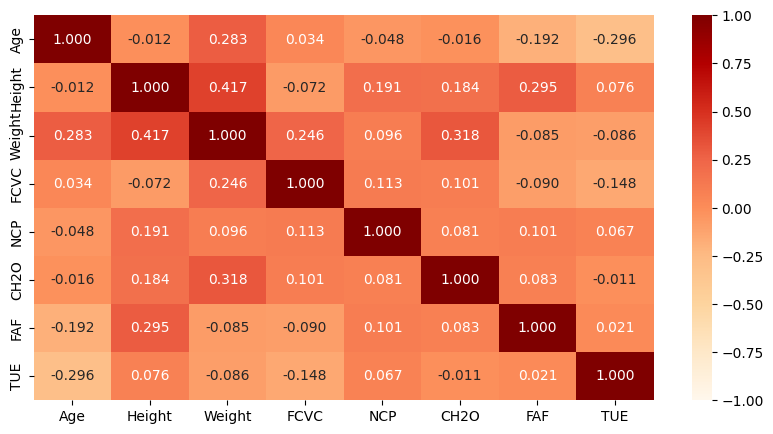

In [13]:
corr_numerical = df_numerical.corr()

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(corr_numerical, annot=True, cmap="OrRd", fmt='.3f', cbar=True, vmin=-1, vmax=1)
plt.show()

### Categorical DataFrame

In [ ]:
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


## Encoding

In [ ]:
df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
# One-Hot encoding
df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)

# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis = 1)

df_encoded

### Concatenate all features together

In [ ]:
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [17]:
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    #객체 생성

    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)
    
    # one feature of df_encoded is redundant; we can remove it
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis = 1)
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)
    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [18]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')
        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.537644  1.695675  1.241770  0.924049  0.338364  1.308584 -0.150721   
1 -0.499620 -1.148152 -0.829748 -0.836279 -2.497077  1.595165  0.021775   
2  0.379434 -0.651587  0.898933  1.039171  0.338364  0.973714 -1.171141   
3 -0.503267 -1.685011  0.598259 -0.836279  0.307045  1.244138 -1.057992   
4  0.379434 -0.834373  0.642469  1.039171  0.338364  1.025738 -1.171141   

    

In [ ]:
sns.set_style('dark')

plt.figure(figsize=(20, 15))

for i in range(df_all_features.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.hist(df_all_features.iloc[:, i], bins=20, label='train')
    plt.hist(df_test.iloc[:, i], bins=20,
             alpha=1, label='test', color='C3')
    plt.title(df_all_features.columns[i])
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

### Labels

In [ ]:
labels['NObeyesdad'].unique()

In [ ]:
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


In [ ]:
sns.set_style('dark')

plt.figure(figsize=(10,6))
plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
plt.grid()
plt.xticks(np.arange(0, 6.1),
          ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
          rotation= 90)

plt.ylabel('Frequency')
plt.show()

## 3.Prepare data for machine learning

In [23]:
X = df_all_features
# 머신러닝 모델을 훈련할 때는 대부분의 경우 np.ravel()을 사용하여 타겟 변수를 1차원 배열로 변환하는 것이 안전함.
y = np.ravel(labels_encoded)

# compare train and test data
X_test = df_test
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Number of samples 20758
Number of featires 19


## Fit the data with baseline models

In [24]:
'''
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y),
                                     y=y)

class_weights = dict(zip(np.unique(y), class_weights))
class_weights
'''

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# calculate class weights based on the training data\nclass_weights = compute_class_weight('balanced', \n                                     classes=np.unique(y),\n                                     y=y)\n\nclass_weights = dict(zip(np.unique(y), class_weights))\nclass_weights\n"

In [25]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 19
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [27]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.895
Overfitting detected
LightGBM
Train score 0.981
Test score 0.905
Overfitting detected
Gradient Boosting
Train score 0.923
Test score 0.903
XGBoost
Train score 0.987
Test score 0.905
Overfitting detected


## 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [28]:
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        # XGBoost
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
    
    else:
        # LightGBM
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [ ]:
# Uncomment this section if you want to do hyperparameter tuning

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-02-26 13:05:55,762] A new study created in memory with name: no-name-d5e5acc8-9602-4725-b165-352acb89ee30


Training the model with 19 features


In [ ]:
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

In [ ]:
# XGBoost 최적 하이퍼파라미터 출력
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' 키 제거
xgboost_params.pop('value')  # 'value' 키 제거
xgboost_params.pop('datetime_start')  # 'datetime_start' 키 제거
xgboost_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
xgboost_params.pop('duration')  # 'duration' 키 제거
xgboost_params.pop('state')  # 'state' 키 제거
xgboost_params.pop('params_model')


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM 최적 하이퍼파라미터 출력
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' 키 제거
lightgbm_params.pop('value')  # 'value' 키 제거
lightgbm_params.pop('datetime_start')  # 'datetime_start' 키 제거
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' 키 제거
lightgbm_params.pop('duration')  # 'duration' 키 제거
lightgbm_params.pop('state')  # 'state' 키 제거
lightgbm_params.pop('params_model')

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please un comment the following cell.

## 6. Train the best model and export the results

In [ ]:
# train the best model
clf_XGB = XGBClassifier(**best_params_XGB)
# clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)

clf_XGB.fit(X, y)

predictions = clf_XGB.predict(X_test)


In [ ]:
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.to_csv('submission.csv', index=False)


In [ ]:
df_features = pd.DataFrame(clf_XGB.feature_importances_, index = X.columns, columns = ['Feature importances'])
df_features = df_features.sort_values('Feature importances')

df_features.plot(kind='barh')
plt.grid()
plt.xlabel('Feature importance')
plt.show()

In [ ]:
clf_LGBM = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)
clf_LGBM.fit(X, y)
predictions = clf_LGBM.predict(X_test)

df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.to_csv('submission.csv')


In [ ]:
df_features = pd.DataFrame(clf_LGBM.feature_importances_, index = X.columns, columns = ['Feature importances'])
df_features = df_features.sort_values('Feature importances')

df_features.plot(kind='barh')
plt.grid()
plt.xlabel('Feature importance')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 의사결정나무 모델 정의
rf = RandomForestClassifier()

# 탐색할 하이퍼파라미터 분포 설정
parameters = {
    'n_estimators': randint(100, 2000),  # 수정된 부분
    'max_depth': randint(1, 4),
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(1, 10)
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(rf, param_distributions=parameters, n_iter=10, cv=3)
random_search.fit(X, y)
best_params_RS = random_search.best_params_
print(best_params_RS)
# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)


스태킹

In [ ]:
def objective(trial):
    
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2),
        'random_strength': trial.suggest_int('random_strength', 0, 50),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.00),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.5, 5.0),
        'loss_function': 'MultiClass' 
    }

    
    clf = CatBoostClassifier(**param, verbose=False)
    
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score
    


study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective, n_trials=5)



In [ ]:
df_study_cat = study_cat.trials_dataframe()
df_study_cat = df_study_cat.sort_values(by='value', ascending=False)

#df_study_cat
best_params_cat = study_cat.best_params


In [ ]:
clf_cat = CatBoostClassifier(**best_params_cat)

clf_cat.fit(X_train, y_train)

predictions = clf_cat.predict(X_test) 


In [ ]:
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
    ('catboost', CatBoostClassifier(**best_params_cat)),    
]

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

In [ ]:
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

In [ ]:
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')


## 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test, stacking_model):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        stacking_model.fit(X_train, y_train)
        
        y_pred_val = stacking_model.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test = stacking_model.predict(X_test)
        predictions.append(y_pred_test)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(stacking_model)
        
    return scores, np.array(predictions), clfs

In [ ]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test, stacking_model)

In [ ]:
print('Average evaluation score = ', np.mean(scores))

In [ ]:
y_test_pred = np.mean(predictions, axis=0)

y_test_pred

In [ ]:
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

In [ ]:
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission.csv')

Explore results of one of the model previously trained

In [ ]:
# # this section works only for XGBoost

# results = clfs[0].evals_result()

# train_loss = results['validation_0']['mlogloss']
# validation_loss = results['validation_1']['mlogloss']
# epochs_grid = np.arange(1, len(train_loss)+1)

# plt.plot(epochs_grid, train_loss, label='Training')
# plt.plot(epochs_grid, validation_loss, label='Validation')
# plt.legend()
# plt.ylabel('loss')
# plt.xlabel('Epochs')
# plt.grid()

## 8. Try to improve accuracy using cross validation
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [ ]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

In [ ]:
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

print(df_submission)

df_submission.to_csv('submission.csv', index=False)